## Business Case

As Data Scientists working for a home renovation company, we were given the task to investigate and predict the average housing prices in the next two years using various zip codes in Springfield, MO. Using data from 1996 to 2018, we will use various time series models to determine which zip code would be the best investment to buy houses in to renovate.

In [1]:
import pandas as pd

In [2]:
springfield = pd.read_csv('data/springfield.csv', index_col='date')
springfield.index = pd.to_datetime(springfield.index)
springfield

,65807,65802,65804,65810,65806,65809
date,,,,,,
1996-04-01,80800.0,64800.0,83200.0,117900.0,38800.0,158200.0
1996-05-01,80800.0,64100.0,83200.0,116800.0,38500.0,158000.0
1996-06-01,80900.0,63500.0,83300.0,115900.0,38200.0,158000.0
1996-07-01,81100.0,63000.0,83500.0,115200.0,38000.0,158100.0
1996-08-01,81400.0,62600.0,83700.0,114800.0,37600.0,158300.0
...,...,...,...,...,...,...
2017-12-01,119900.0,94800.0,141800.0,192000.0,61000.0,257400.0
2018-01-01,120500.0,95400.0,141800.0,192900.0,61600.0,257500.0
2018-02-01,121400.0,95900.0,142800.0,195000.0,61700.0,260400.0


## Autocorrelation and Partial Autocorrelation

Autocorrelation (ACF) helps us study how each time series observations is related to the past.  
Partial Autocorrelation (PACF) gives us a correlation of a time series with its own lagged values, controlling forthe values of the time series at all shorter lags.  
  
These charts will help us determine the starting orders in a ARMA model.

In [3]:
from scripts import acf_pacf_charts

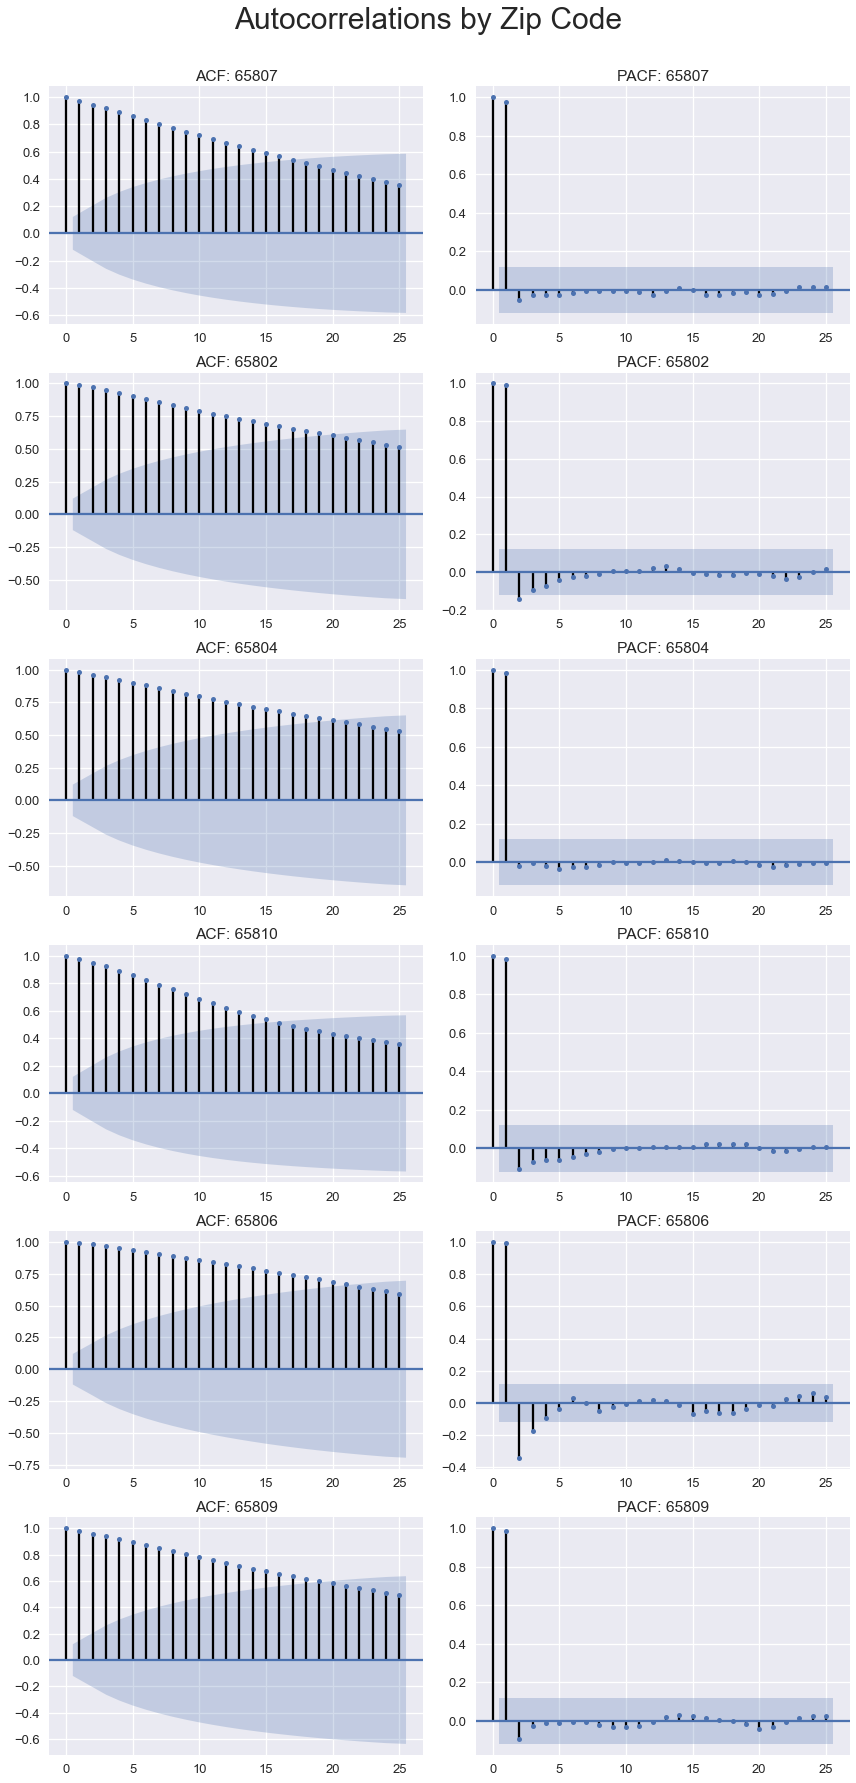

In [4]:
acf_pacf_charts(springfield, filename='autocorrelations')

The gently downwards-sloping autocorrelation plots indicate a high autocorrelation with a difference of one. The partial autocorrelation plots confirm this. We also do not see any autocorrelation with twelve, verifying our lack of seasonality we found in our EDA. We will use this data to chose our order for the baseline ARIMA model.

## Baseline ARIMA

In [3]:
from scripts import arima_analyze, arima_cross_validation

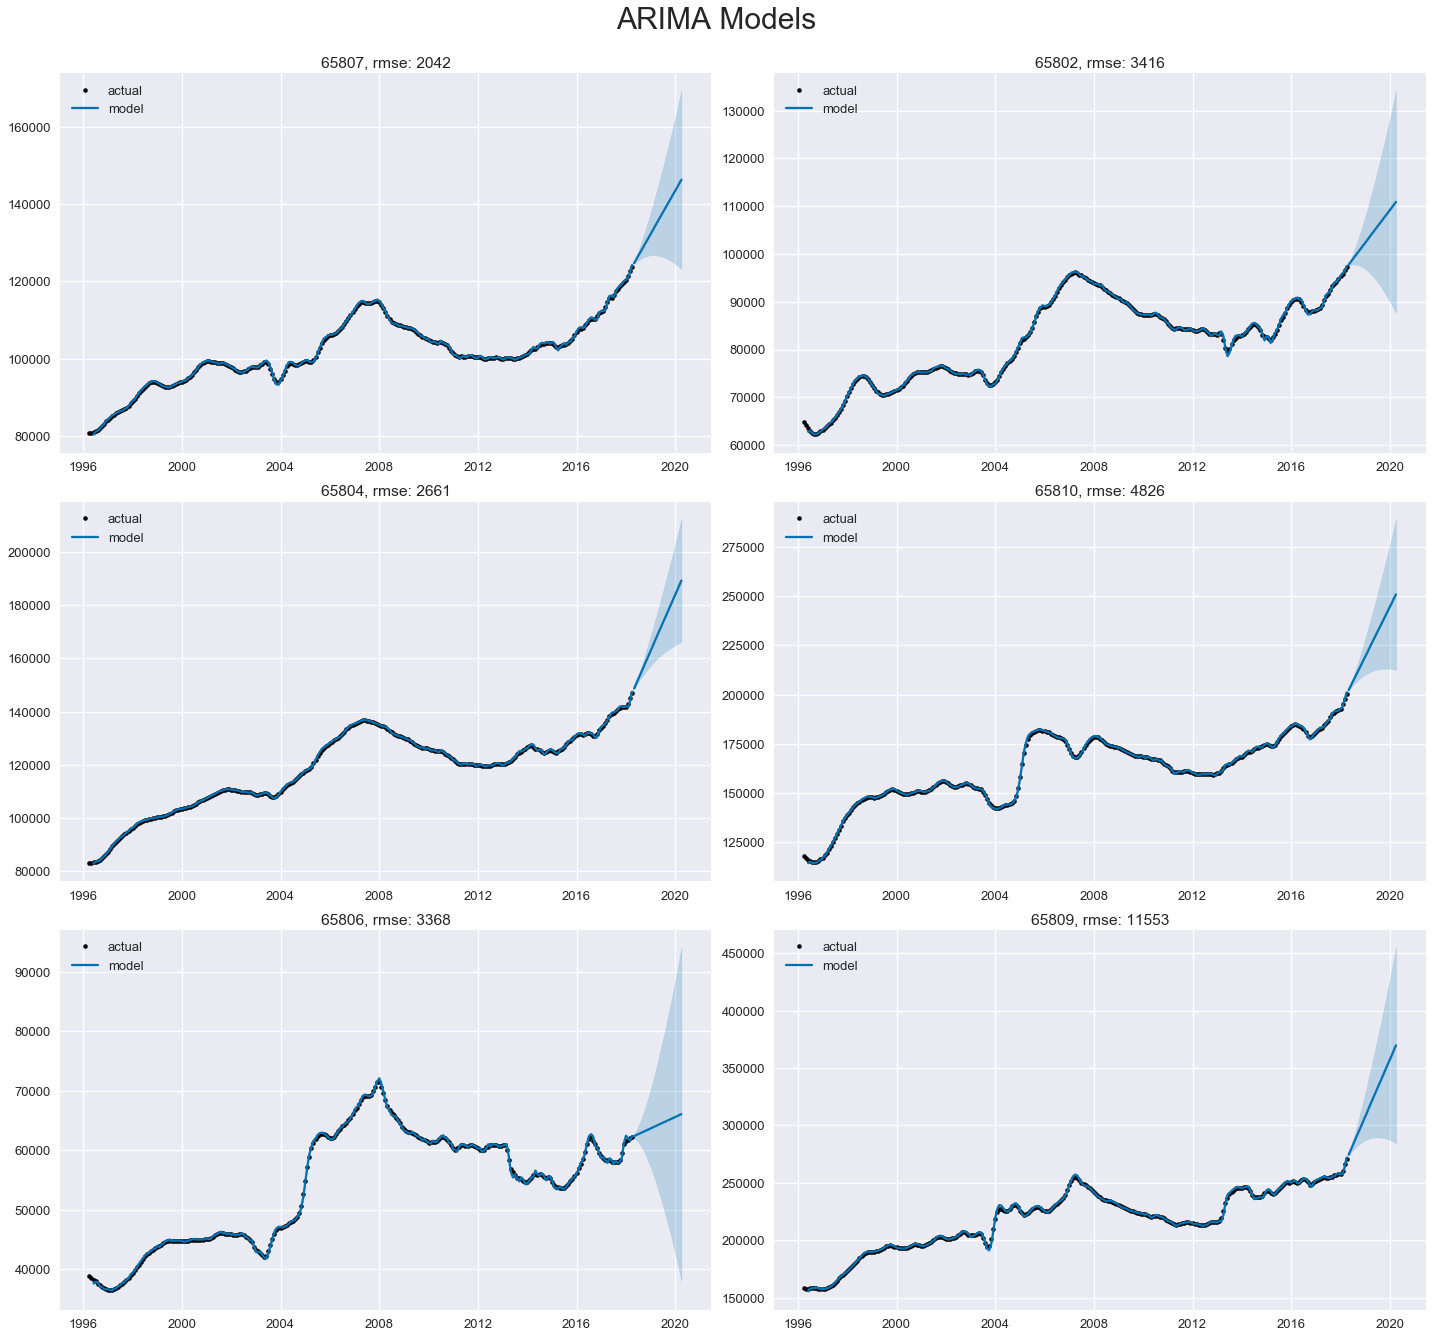

In [4]:
# order (1, 2, 0) chosen based on eda
baseline_arima_forecasts = arima_analyze(springfield, (1,2,0), filename='arima-baselines')

In [5]:
baseline_arima_forecasts.tail()

,65807,65802,65804,65810,65806,65809
2019-12-01,142608.066618,108620.293529,182252.894643,242481.876901,65424.108209,353233.647886
2020-01-01,143548.019237,109190.875495,184020.434006,244595.504484,65584.530419,357375.223612
2020-02-01,144487.971857,109761.457461,185787.973369,246709.132067,65744.952629,361516.799337
2020-03-01,145427.924477,110332.039427,187555.512732,248822.759650,65905.374838,365658.375063
2020-04-01,146367.877097,110902.621393,189323.052095,250936.387233,66065.797048,369799.950789


This is the baseline models using ARIMA and the (1, 2, 0) order as determined in our EDA. The models have cross-validated RMSE values of 2042, 3416, 2661, 4826, 3368, and 11553. Based on a cursory look at the charts, the 65804 zip code seems to have the sharpest inclune in its forecast, indicating a good investment opportunity.

## Auto-ARIMA

In [8]:
# !pip install pmdarima

In [9]:
from pmdarima.arima import auto_arima

In [10]:
order_dict = {}

for col in springfield.columns:
    auto = auto_arima(springfield[col], max_order=None, start_p=1, start_q=1, 
                      max_p=10, max_q=10, d=2, max_d=5, information_criterion='aic',
                      seasonal=False)
    
    order_dict[col] = auto.get_params()['order']

    print('Results:', col)
    print('order:', auto.get_params()['order'])
    print('aic:', auto.aic(), '\n\n\n')

order_dict

Results: 65807
order: (2, 2, 1)
aic: 3594.326805105192 



Results: 65802
order: (0, 2, 1)
aic: 3557.1182912090926 



Results: 65804
order: (1, 2, 2)
aic: 3627.4542630736646 



Results: 65810
order: (2, 2, 2)
aic: 3896.6764236298245 



Results: 65806
order: (0, 2, 1)
aic: 3606.6102256959575 



Results: 65809
order: (1, 2, 0)
aic: 4344.816633900837 





{'65807': (2, 2, 1),
 '65802': (0, 2, 1),
 '65804': (1, 2, 2),
 '65810': (2, 2, 2),
 '65806': (0, 2, 1),
 '65809': (1, 2, 0)}

In [6]:
# temporary
# order_dict ={'65807': (2, 2, 1),
#              '65802': (0, 2, 1),
#              '65804': (1, 2, 2),
#              '65810': (2, 2, 2),
#              '65806': (0, 2, 1),
#              '65809': (1, 2, 0)}

By running this auto-ARIMA function, we have determined the optimal order for each of our six models. We can use this to create more accurate ARIMA models.

## Final ARIMA

In [7]:
import numpy as np
from statsmodels.tsa.arima_model import ARIMA

Zip Code: 65807
Starting Order: (2, 2, 1)
Final Order: (2, 2, 1)


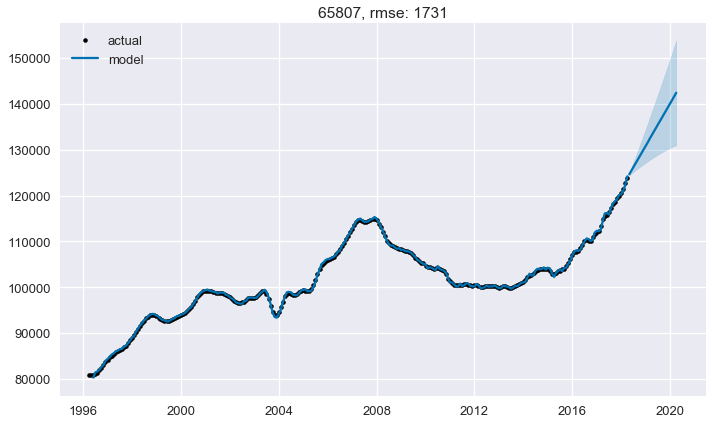

Zip Code: 65802
Starting Order: (0, 2, 1)
Final Order: (0, 2, 1)


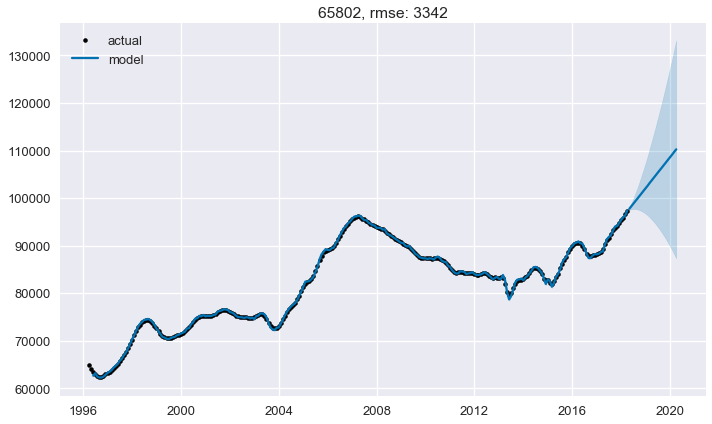

Zip Code: 65804
Starting Order: (1, 2, 2)
Final Order: (1, 2, 2)


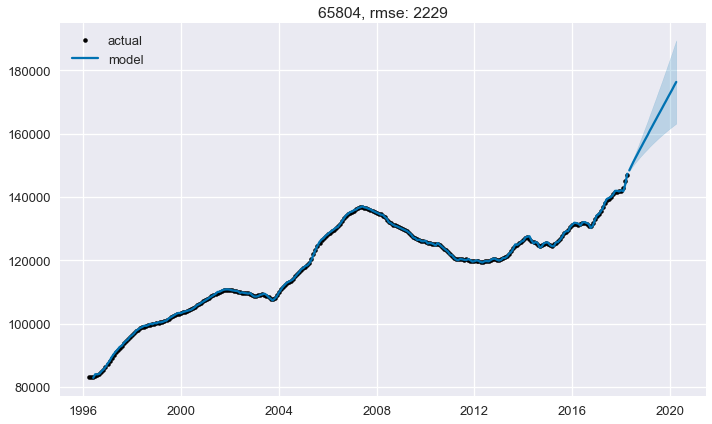

Zip Code: 65810
Starting Order: (2, 2, 2)
Final Order: (2, 2, 2)


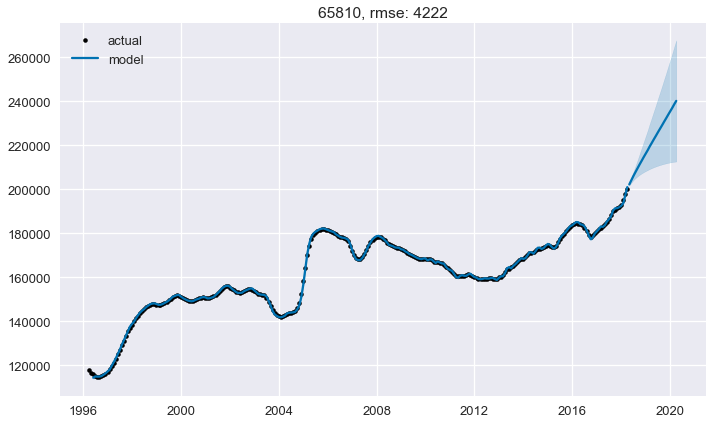

Zip Code: 65806
Starting Order: (0, 2, 1)
Final Order: (0, 2, 1)


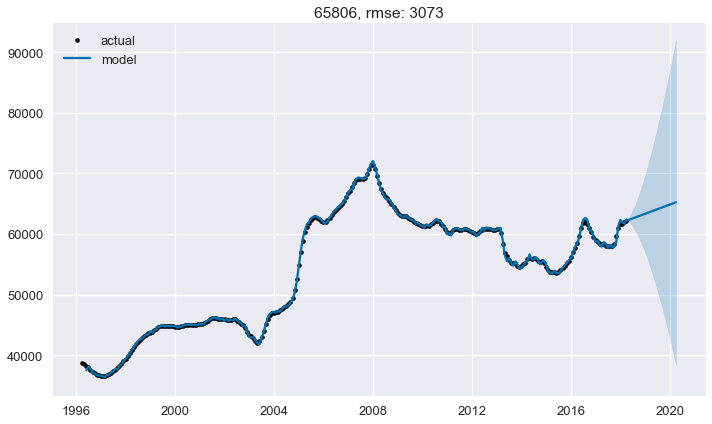

Zip Code: 65809
Starting Order: (1, 2, 0)
Final Order: (1, 2, 0)


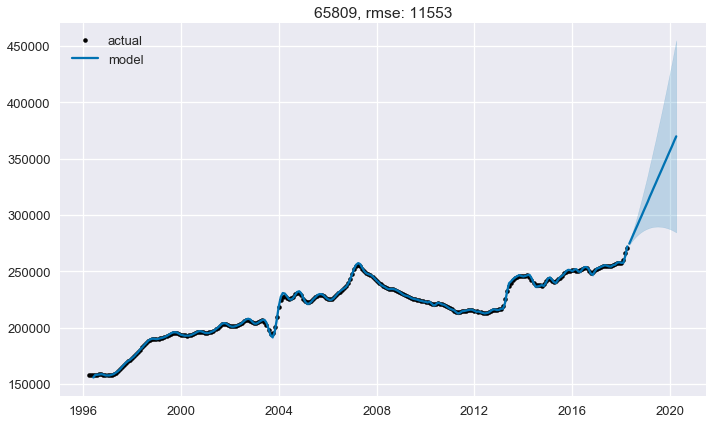

In [8]:
forecasts = {}
rmse_dict = {}

for col in springfield.columns:
    order = order_dict[col]
    model = ARIMA(springfield[col], order=order, freq='MS').fit()
    pvalues = model.pvalues[1:]
    
    print('Zip Code:', col)
    print('Starting Order:', order)
    
    # looping while model still has high p-values
    while np.any(pvalues>0.05):
        # loops over every p-value
        for i, p in pvalues.iteritems():
            if p > .05:
                # ar causing high p-value
                if i.startswith('ar'):
                    print('AR p-value too high, lowered order from', order)
                    order = tuple(np.subtract(order, (1,0,0)))
                # ma causing high p-value
                elif i.startswith('ma'):
                    print('MA p-value too high, lowered order from', order)
                    order = tuple(np.subtract(order, (0,0,1)))
                else:
                    print('Unable to lower order - may need to force stop to prevent infinite loop')
                    continue
                break
                
        model = ARIMA(springfield[col], order=order, freq='MS').fit()
        pvalues = model.pvalues[1:]
        
    
    print('Final Order:', order)
    forecasts[col] = (arima_analyze(springfield[[col]], order, filename=f'arima-final-{col}'))
    
    # collecting rmse into dict for future analysis
    rmses = arima_cross_validation(springfield[col], order)
    rmse = sum(rmses)/len(rmses)
    rmse_dict[col] = int(rmse)
    

Our final models all have different orders. Their rmse are 1731, 3342, 2229, 4222, 3073, and 11553, all lower than their baselines.

Despite the low rmse values, these charts show how closely fit to the data the predictions are, which may indicate overfitting.

Based on the charts, zip codes 65807 and 65804 have the steepest slopes, and might be good investment opportunities.

In [9]:
arima_forecasts = {i:k.values.flatten() for i, k in forecasts.items()}
arima_forecasts['date'] = list(forecasts.values())[0].index
forecasts_df = pd.DataFrame(arima_forecasts)
forecasts_df.set_index('date', inplace=True)
forecasts_df.tail()

,65807,65802,65804,65810,65806,65809
date,,,,,,
2019-12-01,139339.981663,108079.052464,171541.281566,233859.235450,64732.990786,353233.647886
2020-01-01,140112.341416,108623.005087,172732.054216,235450.906312,64859.640326,357375.223612
2020-02-01,140884.701514,109166.957710,173922.813285,237042.395971,64986.289865,361516.799337
2020-03-01,141657.061809,109710.910334,175113.563685,238633.760300,65112.939404,365658.375063
2020-04-01,142429.422217,110254.862957,176304.308555,240225.038176,65239.588944,369799.950789


In [10]:
forecasts_df.to_csv('data/arima_predictions.csv')

In [11]:
arima_rmses = pd.DataFrame.from_dict(rmse_dict.items())
arima_rmses.columns=['zip_code','arima_rmse']
arima_rmses

,zip_code,arima_rmse
0,65807,1731
1,65802,3342
2,65804,2229
3,65810,4222
4,65806,3073
5,65809,11553


In [12]:
arima_rmses.to_csv('data/arima_rmses.csv')